
- Truth data: [120 120]
- Reponse matrix: [[1.0, 0.0], [0.5, 0.5]]
- Observed data: [180.  60.]

prior start
prior done


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


None


Average Loss = 10.947:   2%|▏         | 3499/200000 [00:01<01:10, 2774.75it/s]
Convergence achieved at 3500
Interrupted at 3,499 [1%]: Average Loss = 13.499
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [truth1, truth0]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:07<00:00, 2779.39draws/s]


Elapsed 0:00:11 (1963.01 samples/second)
12.236738199993852 seconds elapsed


/home/jensbd/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel/__main__.py:590: UserWarning: The following kwargs were not used by contour: 'label'
/home/jensbd/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel/__main__.py:594: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/jensbd/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel/__main__.py:621: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/

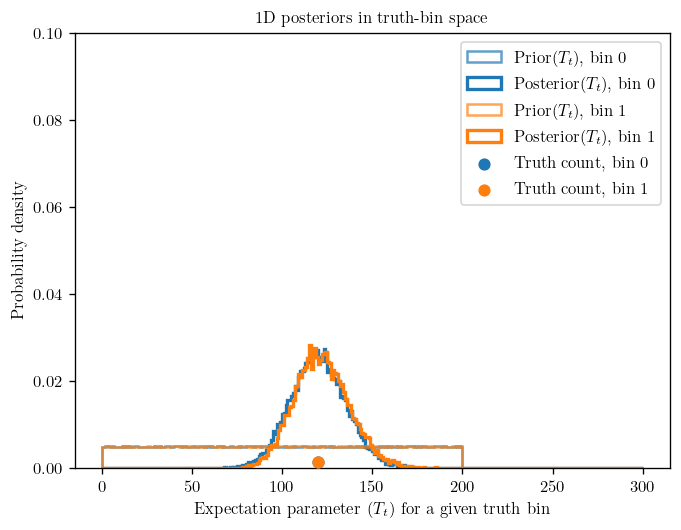

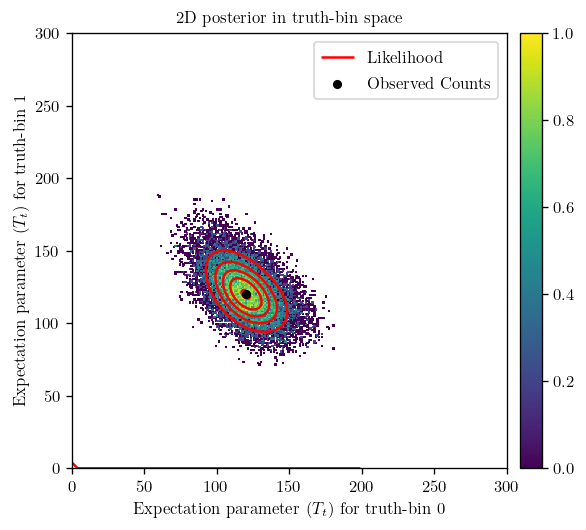

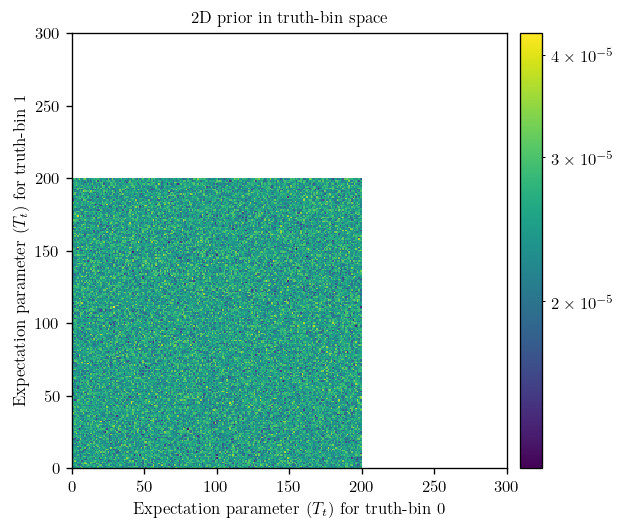

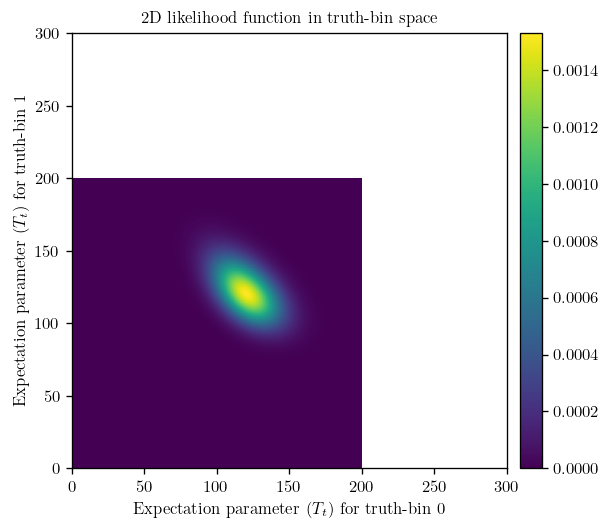

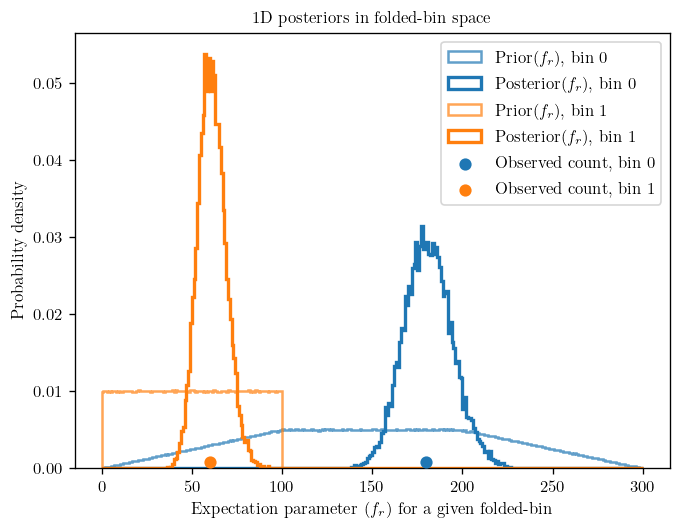

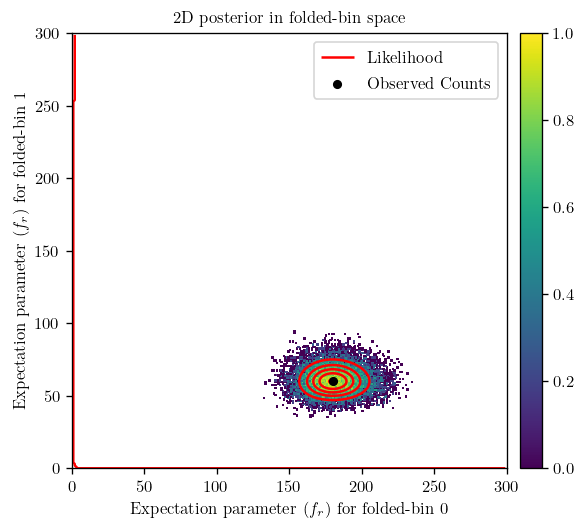

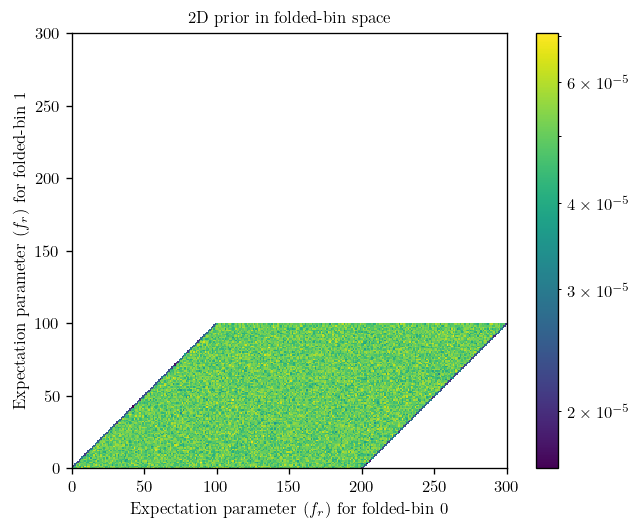

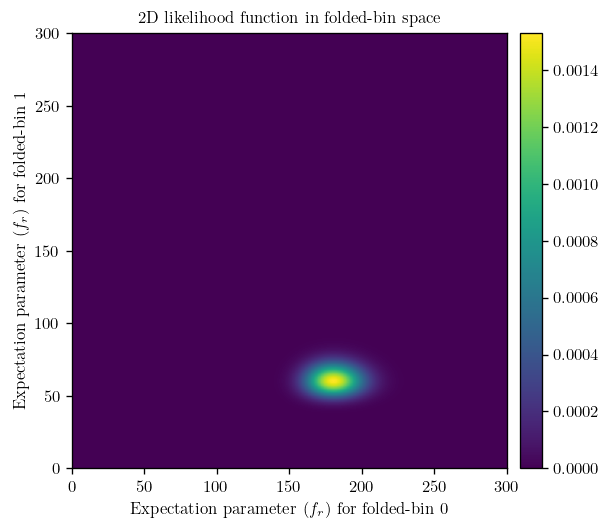

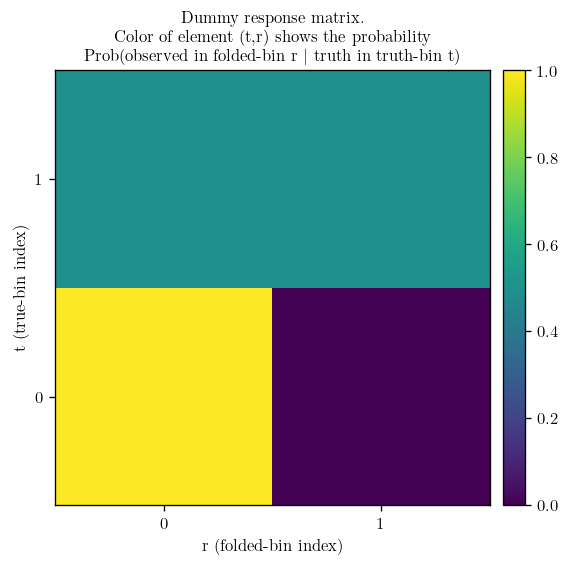

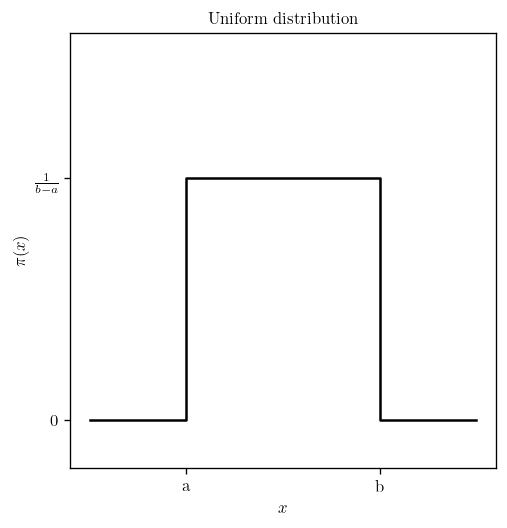

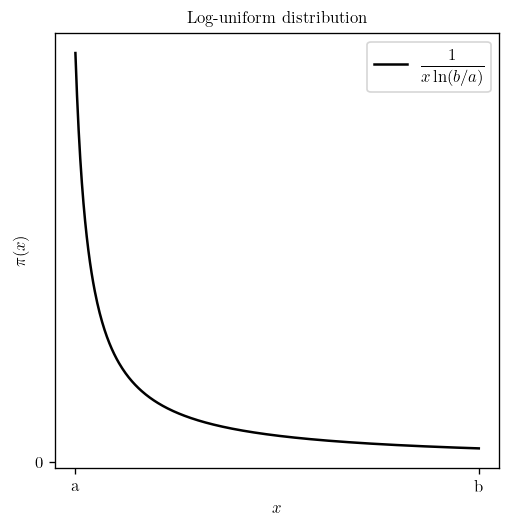

In [52]:

"""
Notes:

- When we map *expectation parameters* from folded-space to truth-space,
  we do so by simply multiplying the response matrix -- we use the 
  expectation values saved in the response matrix

- However, the folded-space data are randomly *generated* from a set 
  of truth-space data. If this generation happens to be unlikely, 
  there will be a *difference* between the peak of the likelihood in truth-space
  and the actual truth-counts we began from.

- However, in the folded-space, the likelihood peak should always match 
  with the data in folded-space (the observed data)

- In other words, given the two processes

  1) actual truth-space data --> [random generation] --> actual folded-space data
  2) actual folded-space data --> [max likelihood] --> estimated folded-space expectations --> [multiply response matrix] --> estimated truth-space expectations

  there is no guarantee that the resulting estimated truth-space expectations must be very 
  close to the actual truth-space data. (The random generation result could have been unlikely!)
  

"""

import fbu
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import uniform, multinomial
import scipy.stats as st
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import pymc3 as mc


from matplotlib import rc
dpi = 120
rc('figure',dpi = dpi)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

rc('figure', figsize = (6,4))
rc('font', size=10)

rc('legend', fontsize = 10)
rc('axes', labelsize = 10)
rc('axes', titlesize = 10)
rc('xtick', labelsize = 10)
rc('ytick', labelsize = 10)


output_dir = "plots"

#
# Create response matrix
#

resp = [[],[]]

# Unit matrix
# resp[1] = [ 0.00,  1.00 ]
# resp[0] = [ 1.00,  0.00 ]

# 20% chance for something that belongs in 
# thruth-bin 1 to be observed in folded-bin 0
# resp[1] = [ 0.20,  0.80 ]
# resp[0] = [ 1.00,  0.00 ]

# 50% chance for something that belongs in 
# thruth-bin 1 to be observed in folded-bin 0
resp[1] = [ 0.50,  0.50 ]
resp[0] = [ 1.00,  0.00 ]

# 20% loss of data in the folded-bin 1
# resp[1] = [ 0.00,  0.80 ]
# resp[0] = [ 1.00,  0.00 ]



#
# Data
#

truth_data = np.array([120,120])

# Generate observed data by sampling according to the response
# data = np.array([0,0])

# for truth_bin_index, truth_bin_count in enumerate(truth_data):

#     truth_to_obs_probabilities = resp[truth_bin_index]

#     # Distribute the truth counts from bin truth_bin_index 
#     # in the observed bins randomly, according to the probabilities 
#     # in truth_to_obs_probabilities (the given row of the response matrix)
#     data += multinomial.rvs(truth_bin_count, truth_to_obs_probabilities)


# Manually set observed data
# data = np.array([120,120])

# Generate pbserved data by direct multiplication with response
data = truth_data@resp



# 
# Print some info
# 

print()
print("- Truth data:", truth_data)
print("- Reponse matrix:", resp)
print("- Observed data:", data)
print()

# data = np.array([100, 0])
# data = np.array([70, 30])
# data = np.array([60, 40])
# data = np.array([50, 50])
# data = np.array([40, 60])
# data = np.array([30, 70])
# data = np.array([0, 100])

n_bins_data = len(data)
data_bin_numbers = list(range(n_bins_data))



# 
# Run FBU
# 

# Create PyFBU object
myfbu = fbu.PyFBU()

myfbu.response = resp
myfbu.data = data 


myfbu.nCores = 4
# myfbu.nChains = 4


# Prior type and bounds
common_prior_l = 0.0
common_prior_u = 200.0

# Prior choices
#######################################################################
prior_choice = 0

# Standard uniform prior
if prior_choice == 0:
    myfbu.prior = 'Uniform'
    
    prior_random_sampling = []
    prior_random_sampling.append(st.uniform.rvs)
    prior_random_sampling.append(st.uniform.rvs)
    
    a = common_prior_l
    b = common_prior_u
    
    prior_args = [a,b]
    # No additional parameters
    prior_kwargs = dict()
    myfbu.priorparams = dict()



# Truncated Normal, PyMC3 built-in class
if prior_choice == 1:
    myfbu.prior = 'TruncatedNormal'

    normal_mu = (common_prior_u - common_prior_l)/2
    normal_std = (common_prior_u - common_prior_l)/4
    myfbu.priorparams = dict(mu = normal_mu, sd = normal_std)
    
    
    prior_random_sampling = []
    prior_random_sampling.append(st.truncnorm.rvs)
    prior_random_sampling.append(st.truncnorm.rvs)
    
    a, b = (common_prior_l - normal_mu) / normal_std, (common_prior_u - normal_mu) / normal_std
    
    prior_args = [a,b]
    prior_kwargs = dict(loc=normal_mu, scale=normal_std)

# Interpolated
if prior_choice == 2:
    myfbu.prior = 'Interpolated'
    
#     x_values = np.linspace(common_prior_l,common_prior_u, int(common_prior_u - common_prior_l))
#     pdf_values = [np.zeros(len(x_values)), np.zeros(len(x_values))]
    
# #     first_mu = (common_prior_u - common_prior_l)/4
#     first_mu = 0
#     normal_std = (common_prior_u - common_prior_l)/1000
#     a, b = (common_prior_l - first_mu) / normal_std, (common_prior_u - first_mu) / normal_std
    
#     first_half = st.truncnorm.pdf(x_values, a, b, first_mu, normal_std)
    
# #     second_mu = (common_prior_u - common_prior_l)*3/4
# #     a, b = (common_prior_l - second_mu) / normal_std, (common_prior_u - second_mu) / normal_std
# #     second_half = st.truncnorm.pdf(x_values, a, b, second_mu, normal_std)
    
# #     second_half = np.zeros(len(x_values))
# #     second_half[50:] = 1/(len(x_values))
    
    
# #     first_half = np.zeros(len(x_values))
#     second_half = np.zeros(len(x_values))
    
    
# #     normal_mu = (common_prior_u - common_prior_l)/2
# #     normal_std = (common_prior_u - common_prior_l)/20
# #     a, b = (common_prior_l - normal_mu) / normal_std, (common_prior_u - normal_mu) / normal_std
# #     second_half = st.truncnorm.pdf(x_values, a, b, normal_mu, normal_std)
    
    
#     first_half = np.zeros(len(x_values))
#     second_half = np.zeros(len(x_values))
    
#     first_half[100:130] = 0.05/len(first_half[100:130])

# #   50% probability total in bin 0 and 1
#     first_half[0] = first_half[1] = 0.25
#     first_half[2:100] = 1e-10
#     first_half[100:130] = 0.5/len(first_half[100:130])
#     first_half[130:] = 1e-10

#     pdf_values[0] = first_half + second_half

    
# #     normal_mu = (common_prior_u - common_prior_l)/2
# #     normal_std = (common_prior_u - common_prior_l)/4
# #     a, b = (common_prior_l - normal_mu) / normal_std, (common_prior_u - normal_mu) / normal_std
# #     pdf_values[1] = st.truncnorm.pdf(x_values, a, b, normal_mu, normal_std)
    
#     pdf_values[1] = first_half + second_half
    pdf_values = []
    x_values = np.logspace(-3, 3, num = 1000)
    pdf_values.append(1.0/x_values)
    pdf_values.append(1.0/x_values)
    
    
    prior_random_sampling = []
#     #
    prior_random_sampling.append(mc.distributions.continuous.Interpolated.dist(x_values, pdf_values[0]).random)
#     #
    prior_random_sampling.append(mc.distributions.continuous.Interpolated.dist(x_values, pdf_values[1]).random)
    
    
    myfbu.priorparams = dict(non_kwargs=[x_values, pdf_values])
    
    # Arguments for prior sampling below, none needed
    prior_kwargs = dict()
    prior_args = []

# Create subclass of Continuous in PyMC3 and use as prior
if prior_choice == 3:
    import pymc3.distributions as distributions
    import theano.tensor as tt
    myfbu.prior = 'CustomDist'
    class CustomDist(distributions.continuous.BoundedContinuous):
        def __init__(self, mu=0, sd=None, tau=None, lower=None, upper=None,
                     transform='auto', *args, **kwargs):
            tau, sd = distributions.continuous.get_tau_sd(tau=tau, sd=sd)
            self.sd = tt.as_tensor_variable(sd)
            self.tau = tt.as_tensor_variable(tau)
            self.lower = tt.as_tensor_variable(lower) if lower is not None else lower
            self.upper = tt.as_tensor_variable(upper) if upper is not None else upper
            self.mu = tt.as_tensor_variable(mu)

            if self.lower is None and self.upper is None:
                self._defaultval = mu
            elif self.lower is None and self.upper is not None:
                self._defaultval = self.upper - 1.
            elif self.lower is not None and self.upper is None:
                self._defaultval = self.lower + 1.
            else:
                self._defaultval = (self.lower + self.upper) / 2

            distributions.continuous.assert_negative_support(sd, 'sd', 'TruncatedNormal')
            distributions.continuous.assert_negative_support(tau, 'tau', 'TruncatedNormal')

            super(CustomDist, self).__init__(
                defaults=('_defaultval',), transform=transform,
                lower=lower, upper=upper, *args, **kwargs)

        def random(self, point=None, size=None):
            """
            Draw random values from TruncatedNormal distribution.

            Parameters
            ----------
            point : dict, optional
                Dict of variable values on which random values are to be
                conditioned (uses default point if not specified).
            size : int, optional
                Desired size of random sample (returns one sample if not
                specified).

            Returns
            -------
            array
            """
            
            mu_v, std_v, a_v, b_v = distributions.draw_values(
                [self.mu, self.sd, self.lower, self.upper], point=point, size=size)
            return distributions.generate_samples(st.truncnorm.rvs,
                                    a=(a_v - mu_v)/std_v,
                                    b=(b_v - mu_v) / std_v,
                                    loc=mu_v,
                                    scale=std_v,
                                    dist_shape=self.shape,
                                    size=size,
                                    )

        def logp(self, value):
            """
            Calculate log-probability of TruncatedNormal distribution at specified value.

            Parameters
            ----------
            value : numeric
                Value(s) for which log-probability is calculated. If the log probabilities for multiple
                values are desired the values must be provided in a numpy array or theano tensor

            Returns
            -------
            TensorVariable
            """
            mu = self.mu
            sd = self.sd

            norm = self._normalization()
            
            print(value, type(value))
            if tt.lt(value, 100):
                mu = 0
            
            logp = distributions.continuous.Normal.dist(mu=mu, sd=sd).logp(value) - norm
            
            bounds = [sd > 0]
            if self.lower is not None:
                bounds.append(value >= self.lower)
            if self.upper is not None:
                bounds.append(value <= self.upper)
            return distributions.dist_math.bound(logp, *bounds)

        def _normalization(self):
            mu, sd = self.mu, self.sd

            if self.lower is None and self.upper is None:
                return 0.

            if self.lower is not None and self.upper is not None:
                lcdf_a = distributions.dist_math.normal_lcdf(mu, sd, self.lower)
                lcdf_b = distributions.dist_math.normal_lcdf(mu, sd, self.upper)
                lsf_a = distributions.dist_math.normal_lccdf(mu, sd, self.lower)
                lsf_b = distributions.dist_math.normal_lccdf(mu, sd, self.upper)

                return tt.switch(
                    self.lower > 0,
                    mc.math.logdiffexp(lsf_a, lsf_b),
                    mc.math.logdiffexp(lcdf_b, lcdf_a),
                )

            if self.lower is not None:
                return normal_lccdf(mu, sd, self.lower)
            else:
                return normal_lcdf(mu, sd, self.upper)
    
    
    prior_random_sampling = CustomDist.random
    
    normal_mu = (common_prior_u - common_prior_l)/2

#     normal_mu = 0
    normal_std = (common_prior_u - common_prior_l)/4
    a, b = (common_prior_l - normal_mu) / normal_std, (common_prior_u - normal_mu) / normal_std
    
    prior_args = [CustomDist.dist(mu = normal_mu, 
                                  sd = normal_std, 
                                  lower = common_prior_l, 
                                  upper = common_prior_u)]
    prior_kwargs = dict()
    
    myfbu.priorparams = dict(CustomDist = CustomDist, mu = normal_mu, sd = normal_std)
    
#######################################################################


myfbu.upper = np.ones(n_bins_data) * common_prior_u
myfbu.lower = np.ones(n_bins_data) * common_prior_l

# Sampling and tuning steps
myfbu.nTune = 1000
myfbu.nMCMC = 10000




from timeit import default_timer as timer

start = timer()

# Perform unfolding 
myfbu.run()

end = timer()
print(end - start, 'seconds elapsed') 


# Get posterior samples
trace = myfbu.trace
# trace[0] contains the posterior samples for the expectation parameter for truth bin 0, etc.
# so let's rename it to something sensible
post_samples_all_tbins = trace



#
# Generate posterior samples for folded bin
#

# A function to get samples for *one* folded bin, 
# given samples for *all* truth bins
def get_fbin_samples(fbin_number, all_tbin_samples):
    n_samples = len(all_tbin_samples[0])
    fbin_samples = np.zeros(n_samples)
    for sample_nr in range(n_samples):

        # We extract one truth-vector from the n_samples different truth vectors in all_tbin_samples.
        tvec_sample = [ all_tbin_samples[i][sample_nr] for i in data_bin_numbers ]

        # We now want to calculate 
        #
        #   f_i =    Prob(E_folded bin i | E_truth bin 0) * t_0  
        #          + Prob(E_folded bin i | E_truth bin 1) * t_1  
        #          + Prob(E_folded bin i | E_truth bin 2) * t_2  
        #          + ...  
        #
        # which corresponds to Eq. 4 in https://arxiv.org/pdf/1201.4612.pdf (but with very different notation!)
        # Let's do the sum as a simple loop, so we don't get confused.
        
        fbin_sample = 0
        for i in data_bin_numbers:
            t_i_sample = tvec_sample[i]
            fbin_sample += resp[i][fbin_number] * t_i_sample

        # We now have one sample value for the parameter f (expected count) 
        # for the chosen folded bin (fbin_number). Let's save it and get the next one.
        fbin_samples[sample_nr] = fbin_sample

    return fbin_samples

# Use the above function to generate posterior samples for each of the f parameters (one per fbin)
post_samples_all_fbins = []
for i in data_bin_numbers:
    post_samples_fbin_i = get_fbin_samples(i, post_samples_all_tbins)
    post_samples_all_fbins.append(post_samples_fbin_i)


#
# Generate prior samples in truth-bin space and folded-bin space
#

# Since it's so quick to generate prior samples, we can 
# generate enough to get very smooth histograms
n_prior_samples = 100 * len(post_samples_all_tbins[0])

# First draw prior samples in truth-bin space
prior_samples_all_tbins = []
for i in data_bin_numbers:
#     prior_samples_bin_i = list( uniform.rvs(common_prior_l, common_prior_u, size=n_prior_samples) )
    prior_samples_bin_i = list( prior_random_sampling[i](*prior_args, size=n_prior_samples, **prior_kwargs) )
    prior_samples_all_tbins.append( prior_samples_bin_i )

# Then translate to a correponding set of prior samples in folded-bin space
prior_samples_all_fbins = []
for i in data_bin_numbers:
    prior_samples_fbin_i = get_fbin_samples(i, prior_samples_all_tbins)
    prior_samples_all_fbins.append(prior_samples_fbin_i)


#
# Calculate the 2D likelihood function in both folded-bin space and truth-bin space
#

def loglikelihood_folded_space(fval_bin_0, fval_bin_1):

    loglikelihood = 0.0
    loglikelihood += data[0] * np.log(fval_bin_0) - fval_bin_0 - np.sum(np.log(np.arange(1, data[0]+1)))
    loglikelihood += data[1] * np.log(fval_bin_1) - fval_bin_1 - np.sum(np.log(np.arange(1, data[1]+1)))

    return loglikelihood

# Evaluate 2D likelihood function in folded-bin space
# Will plot this function further down

f0_range = np.arange(common_prior_l, common_prior_u, 1)
f1_range = np.arange(common_prior_l, common_prior_u, 1)

########################################################
f0_range = np.arange(0, 300, 1)
f1_range = np.arange(0, 300, 1)
########################################################

F0,F1 = np.meshgrid(f0_range, f1_range) 
# Note exponentiation
likelihood_folded_space = np.exp(loglikelihood_folded_space(F0, F1))


def loglikelihood_truth_space(tval_bin_0, tval_bin_1):

    fval_bin_0 = 0
    fval_bin_0 += resp[0][0] * tval_bin_0
    fval_bin_0 += resp[1][0] * tval_bin_1

    fval_bin_1 = 0
    fval_bin_1 += resp[0][1] * tval_bin_0
    fval_bin_1 += resp[1][1] * tval_bin_1

    return loglikelihood_folded_space(fval_bin_0, fval_bin_1)

# Evaluate 2D likelihood function in truth-bin space
# Will plot this function further down

t0_range = np.arange(common_prior_l, common_prior_u, 1)
t1_range = np.arange(common_prior_l, common_prior_u, 1)
T0,T1 = np.meshgrid(t0_range, t1_range) 
# Note exponentiation
likelihood_truth_space = np.exp(loglikelihood_truth_space(T0, T1))



#
# Plotting
#

figsize = (6.4, 4.8)
# figsize = (5, 3.75)
# figsize = (4, 3)
fontsize = 10
mpl.rcParams['font.size'] = fontsize

cmap = plt.get_cmap("tab10")
bin_limits_posterior = np.linspace(common_prior_l, common_prior_u, 101)

bin_limits_posterior = np.linspace(0, 300, 301)

n_bins_posterior_hist = len(bin_limits_posterior) - 1


# --- Plot 1D priors and posteriors in truth-bin space --- 
plt.figure(figsize=figsize)
plt.title("1D posteriors in truth-bin space", fontsize=fontsize)

for i in data_bin_numbers:
    plt.hist(prior_samples_all_tbins[i], bins=bin_limits_posterior, color=cmap(i), histtype='step', density=True, linewidth=1.5, alpha=0.7, label="Prior($T_t$), bin %i" % i)
    plt.hist(post_samples_all_tbins[i], bins=bin_limits_posterior, color=cmap(i), histtype='step', density=True, linewidth=2.0, label="Posterior($T_t$), bin %i" % i)
plt.legend()
plt.ylabel('Probability density')
plt.xlabel(r'Expectation parameter ($T_t$) for a given truth bin')

plt.ylim(0,0.1)

# Add some markers showing the truth data value in each bin
ymin, ymax = plt.gca().get_ylim()
for i in data_bin_numbers:
    truth_data_bin_i = truth_data[i]
    plt.scatter([truth_data_bin_i],[0.015*ymax], marker='o', s=40, color=cmap(i), label="Truth count, bin %i" % i, zorder=5)
plt.legend()

# plt.savefig(os.path.join(output_dir, '1D_priors_posteriors_truth_space.pdf'))


# --- Plot 2D posterior in truth-bin space --- 
plt.figure(figsize=figsize)
# plt.axes().set_aspect('equal')
plt.title("2D posterior in truth-bin space", fontsize=fontsize)

plt.hist2d(post_samples_all_tbins[0], post_samples_all_tbins[1], bins=bin_limits_posterior, density=True, norm=mpl.colors.LogNorm())

cntr = plt.contour(likelihood_truth_space, colors = 'red', levels = 5, label = 'Likelihood')

plt.xlabel(r'Expectation parameter ($T_t$) for truth-bin 0')
plt.ylabel(r'Expectation parameter ($T_t$) for truth-bin 1')
plt.axes().set_aspect('equal', 'box')

# Add a marker showing the truth data point (x,y) = (counts in truth-bin 0, counts in truth-bin 1)
sctr = plt.scatter(truth_data[0], truth_data[1], marker='o', s=20, color='black', label="Truth counts", zorder=5)

h1,_ = cntr.legend_elements()


# plt.legend()
plt.legend([h1[0], sctr], ['Likelihood', 'Observed Counts'])

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(cax=cax)
# plt.clim(1e-5, 1e0)

# plt.savefig(os.path.join(output_dir, '2D_posterior_truth_space.pdf'))


# --- Plot 2D prior in truth-bin space --- 
plt.figure(figsize=figsize)
# plt.axes().set_aspect('equal')
plt.title("2D prior in truth-bin space", fontsize=fontsize)

plt.hist2d(prior_samples_all_tbins[0], prior_samples_all_tbins[1], bins=bin_limits_posterior, density=True, norm=mpl.colors.LogNorm())
plt.xlabel(r'Expectation parameter ($T_t$) for truth-bin 0')
plt.ylabel(r'Expectation parameter ($T_t$) for truth-bin 1')
plt.axes().set_aspect('equal', 'box')

# plt.clim(1e-5, 1e0)
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(cax=cax)

# plt.savefig(os.path.join(output_dir, '2D_prior_truth_space.pdf'))



# --- Plot 2D likelihood function in truth-bin space --- 
plt.figure(figsize=figsize)
# plt.axes().set_aspect('equal')
plt.title("2D likelihood function in truth-bin space", fontsize=fontsize)

im = plt.imshow(likelihood_truth_space, 
#                 extent=[f0_range[0], f0_range[-1], f1_range[0], f1_range[-1]],
                cmap=plt.get_cmap("viridis"),
                origin="lower")

plt.xlim(bin_limits_posterior[0], bin_limits_posterior[-1])
plt.ylim(bin_limits_posterior[0], bin_limits_posterior[-1])

plt.xlabel(r'Expectation parameter ($T_t$) for truth-bin 0')
plt.ylabel(r'Expectation parameter ($T_t$) for truth-bin 1')
plt.axes().set_aspect('equal', 'box')


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)

# plt.savefig(os.path.join(output_dir, '2D_likelihood_truth_space.pdf'))



# --- Plot 1D priors and posteriors in folded-bin space --- 
plt.figure(figsize=figsize)
plt.title("1D posteriors in folded-bin space", fontsize=fontsize)

for i in data_bin_numbers:
    plt.hist(prior_samples_all_fbins[i], bins=bin_limits_posterior, color=cmap(i), histtype='step', density=True, linewidth=1.5, alpha=0.7, label="Prior($f_r$), bin %i" % i)
    plt.hist(post_samples_all_fbins[i], bins=bin_limits_posterior, color=cmap(i), histtype='step', density=True, linewidth=2.0, label="Posterior($f_r$), bin %i" % i)
plt.legend()
plt.ylabel('Probability density')
plt.xlabel(r'Expectation parameter ($f_r$) for a given folded-bin')

# Add some markers showing the data value in each bin
ymin, ymax = plt.gca().get_ylim()
for i in data_bin_numbers:
    data_bin_i = data[i]
    plt.scatter([data_bin_i],[0.015*ymax], marker='o', s=40, color=cmap(i), label="Observed count, bin %i" % i, zorder=5)
plt.legend()

# plt.savefig(os.path.join(output_dir, '1D_priors_posteriors_folded_space.pdf'))



# --- Plot 2D posterior in folded-bin space --- 
plt.figure(figsize=figsize)
plt.title("2D posterior in folded-bin space", fontsize=fontsize)

plt.hist2d(post_samples_all_fbins[0], post_samples_all_fbins[1], bins=bin_limits_posterior, density=True, norm=mpl.colors.LogNorm())

cntr = plt.contour(likelihood_folded_space, colors = 'red', levels = 5, label = 'Likelihood')


plt.xlabel(r'Expectation parameter ($f_r$) for folded-bin 0')
plt.ylabel(r'Expectation parameter ($f_r$) for folded-bin 1')
plt.axes().set_aspect('equal', 'box')

# Add a marker showing the data point (x,y) = (observed counts in bin 0, observed counts in bin 1)
sctr = plt.scatter(data[0], data[1], marker='o', s=20, color='black', label="Observed counts", zorder=5)

h1,_ = cntr.legend_elements()


# plt.legend()
plt.legend([h1[0], sctr], ['Likelihood', 'Observed Counts'])

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(cax=cax)

# plt.savefig(os.path.join(output_dir, '2D_posterior_folded_space.pdf'))


# --- Plot 2D prior in folded-bin space --- 
plt.figure(figsize=figsize)
plt.title("2D prior in folded-bin space", fontsize=fontsize)

plt.hist2d(prior_samples_all_fbins[0], prior_samples_all_fbins[1], bins=bin_limits_posterior, density=True, norm=mpl.colors.LogNorm())
plt.colorbar()
# plt.clim(1e-5, 1e0)
plt.xlabel(r'Expectation parameter ($f_r$) for folded-bin 0')
plt.ylabel(r'Expectation parameter ($f_r$) for folded-bin 1')
plt.axes().set_aspect('equal', 'box')

# plt.savefig(os.path.join(output_dir, '2D_prior_folded_space.pdf'))



# --- Plot 2D likelihood function in folded-bin space --- 
plt.figure(figsize=figsize)
plt.title("2D likelihood function in folded-bin space", fontsize=fontsize)

im = plt.imshow(likelihood_folded_space, 
#                 extent=[common_prior_l, common_prior_u, common_prior_l, common_prior_u],
                cmap=plt.get_cmap("viridis"),
                origin="lower")

plt.xlim(bin_limits_posterior[0], bin_limits_posterior[-1])
plt.ylim(bin_limits_posterior[0], bin_limits_posterior[-1])

plt.xlabel(r'Expectation parameter ($f_r$) for folded-bin 0')
plt.ylabel(r'Expectation parameter ($f_r$) for folded-bin 1')
plt.axes().set_aspect('equal', 'box')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)

# plt.savefig(os.path.join(output_dir, '2D_likelihood_folded_space.pdf'))


# # --- Plot showing the original data --- 
# plt.figure(figsize=figsize)
# plt.title("Data spectrum", fontsize=fontsize)

# plt.scatter(data_bin_numbers, data, color='black')   

# plt.ylim([0, 1.2 * np.max(data)])
# plt.xticks(data_bin_numbers)

# plt.ylabel('Observed counts')
# plt.xlabel('Bin number')

# plt.savefig(os.path.join(output_dir, 'data.pdf'))


# --- Plot response matrix --- 
plt.figure(figsize=figsize)
# plt.imshow(resp, origin="lower", norm=mpl.colors.LogNorm())
plt.imshow(resp, origin="lower",)
plt.xticks(data_bin_numbers)
plt.yticks(data_bin_numbers)

plt.title("Dummy response matrix.\nColor of element (t,r) shows the probability\nProb(observed in folded-bin r $|$ truth in truth-bin t)", fontsize=fontsize)
plt.xlabel("r (folded-bin index)")
plt.ylabel("t (true-bin index)")
plt.axes().set_aspect('equal', 'box')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(cax=cax)
# plt.clim(1e-2, 1e0)
plt.clim(0.0, 1.0)

# plt.savefig(os.path.join(output_dir, 'response_matrix.pdf'))



# Plot uniform distribution for display in thesis
plt.figure(figsize=figsize)

plt.step([0,2,4,6,8], [0,0,5,5,0], color = 'black')


plt.xticks([2,6], ['a','b'])
plt.yticks([0,5],[r'$0$', r'$\frac{1}{b-a}$'])


plt.ylim(-1,8)
plt.title('Uniform distribution')
plt.xlabel("$x$")
plt.ylabel("$\pi(x)$")
plt.axes().set_aspect('equal', 'box')


# Plot log-uniform distribution for display in thesis
plt.figure(figsize=figsize)

x_range = np.linspace(0.1,3,500)
b = x_range[-1]
a = x_range[0]

plt.plot(x_range, 1/(x_range*np.log(b/a)), color = 'black', label = r'$$\frac{1}{x\ln(b/a)}$$')

plt.legend()
plt.xticks([a,b], ['a','b'])
plt.yticks([0],['$0$'])


# plt.ylim(-1,1)
plt.title('Log-uniform distribution')
plt.xlabel("$x$")
plt.ylabel("$\pi(x)$")
plt.axes().set_aspect('equal', 'box')

# Show all plots
plt.show()